In [1]:
# 운영 체제마다 한글이 보이게 하는 설정
# 윈도우
import platform
import matplotlib
from matplotlib import font_manager, rc

# '-' 기호 보이게 하기
matplotlib.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "C:\\Windows\\Fonts\\malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tempfile
import joblib

# 데이터 불러오기
data = pd.read_csv('../1. 행정동_상위변수_데이터/행정동_음주운전_합본_cp949.csv', encoding='cp949')

# Feature와 Target 분리
X = data.drop(columns=['읍면동', '음주운전 적발 건수'])
y = data['음주운전 적발 건수']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29)

# 데이터 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA 적용
pca = PCA(n_components=0.95, random_state=29)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# XGBoost 모델 설정
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=29)

# 하이퍼 파라미터 그리드 설정
param_grid = {
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.5, 1],
    'min_child_weight': [1, 3, 5],
    'alpha': [0, 0.1, 0.5],
    'lambda': [0.5, 1, 2]
}

# 미리 C:\temp 폴더 생성 후 사용
temp_folder = tempfile.mkdtemp(dir="C:\\temp")

grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

# Grid Search 학습 시, 임시 폴더 명시적으로 지정
with joblib.parallel_backend('loky', temp_folder=temp_folder):
    grid_search.fit(X_train_pca, y_train)

# 최적 모델 선택
best_model = grid_search.best_estimator_

# 예측 및 평가
y_pred = best_model.predict(X_test_pca)

# 평가 지표 계산
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 평가 지표 출력
print(f"최적 하이퍼파라미터: {grid_search.best_params_}")
print(f"XGBoost MSE: {mse}")
print(f"XGBoost MAE: {mae}")
print(f"XGBoost RMSE: {rmse}")
print(f"XGBoost R2 Score: {r2}")


Fitting 5 folds for each of 8748 candidates, totalling 43740 fits
최적 하이퍼파라미터: {'alpha': 0, 'colsample_bytree': 0.8, 'gamma': 0.5, 'lambda': 0.5, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9}
XGBoost MSE: 0.6491390861129589
XGBoost MAE: 0.520833684147858
XGBoost RMSE: 0.8056916817945676
XGBoost R2 Score: 0.902387416931859


In [6]:
# PCA 로딩 행렬 출력
loading_matrix = pd.DataFrame(
    pca.components_,  # 주성분 계수 행렬
    columns=X.columns,  # 원본 변수명
    index=[f"PC{i+1}" for i in range(pca.n_components_)]  # 주성분 이름
)

print("PCA 로딩 행렬:")
loading_matrix

PCA 로딩 행렬:


,자동차 등록 대수,인구수,횡단보도 개수,음식점 수,버스정류장 개수,음주 교통사고 건수
PC1,0.409747,0.460800,0.403554,0.296010,0.406990,0.451279
PC2,-0.281225,-0.365493,0.581489,-0.163916,0.575117,-0.302604
PC3,-0.131059,-0.179204,-0.083363,0.933893,0.032749,-0.265579
PC4,0.849404,-0.269566,0.011872,-0.058490,-0.021025,-0.449269


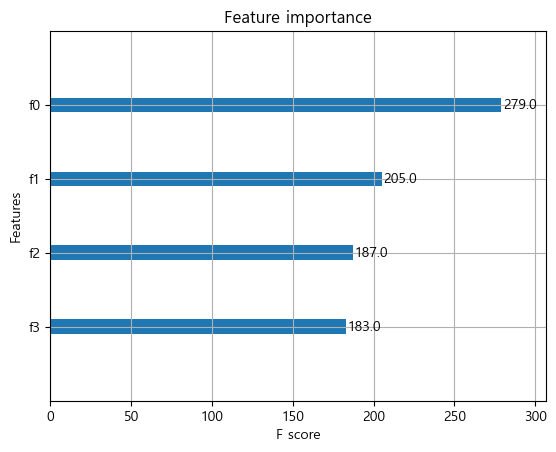

In [7]:
import matplotlib.pyplot as plt
xgb.plot_importance(best_model)
plt.show()



PCA 로딩 행렬:
     자동차 등록 대수       인구수   횡단보도 개수     음식점 수  버스정류장 개수  음주 교통사고 건수
PC1   0.409747  0.460800  0.403554  0.296010  0.406990    0.451279
PC2  -0.281225 -0.365493  0.581489 -0.163916  0.575117   -0.302604
PC3  -0.131059 -0.179204 -0.083363  0.933893  0.032749   -0.265579
PC4   0.849404 -0.269566  0.011872 -0.058490 -0.021025   -0.449269


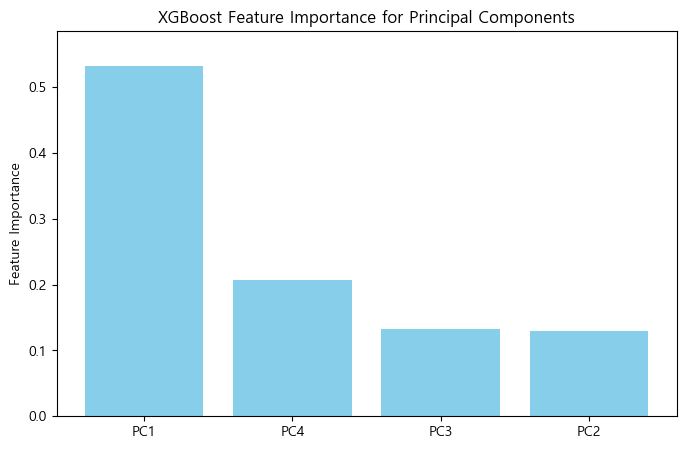


XGBoost가 중요하게 여긴 주성분:
    PC  Importance
0  PC1    0.531840
3  PC4    0.206660
2  PC3    0.132308
1  PC2    0.129191

PC1 (중요도: 0.5318) 관련 원본 변수:
자동차 등록 대수     0.409747
인구수           0.460800
횡단보도 개수       0.403554
음식점 수         0.296010
버스정류장 개수      0.406990
음주 교통사고 건수    0.451279
Name: PC1, dtype: float64

PC4 (중요도: 0.2067) 관련 원본 변수:
자동차 등록 대수     0.849404
인구수          -0.269566
횡단보도 개수       0.011872
음식점 수        -0.058490
버스정류장 개수     -0.021025
음주 교통사고 건수   -0.449269
Name: PC4, dtype: float64

PC3 (중요도: 0.1323) 관련 원본 변수:
자동차 등록 대수    -0.131059
인구수          -0.179204
횡단보도 개수      -0.083363
음식점 수         0.933893
버스정류장 개수      0.032749
음주 교통사고 건수   -0.265579
Name: PC3, dtype: float64

PC2 (중요도: 0.1292) 관련 원본 변수:
자동차 등록 대수    -0.281225
인구수          -0.365493
횡단보도 개수       0.581489
음식점 수        -0.163916
버스정류장 개수      0.575117
음주 교통사고 건수   -0.302604
Name: PC2, dtype: float64


In [15]:
# PCA 로딩 행렬 출력
print("\nPCA 로딩 행렬:")
print(loading_matrix)

# XGBoost가 중요하게 선택한 주성분이 원본 변수들과 어떤 관계인지 분석
feature_importance = best_model.feature_importances_

# 각 주성분의 중요도를 데이터프레임으로 정리
pc_importance = pd.DataFrame(
    {'PC': [f'PC{i+1}' for i in range(pca.n_components_)], 'Importance': feature_importance}
).sort_values(by='Importance', ascending=False)

# 그래프 시각화
plt.figure(figsize=(8, 5))
plt.bar(pc_importance['PC'], pc_importance['Importance'], color='skyblue')
plt.ylabel('Feature Importance')
plt.title('XGBoost Feature Importance for Principal Components')
plt.ylim(0, max(pc_importance['Importance']) * 1.1)  # Y축 범위 설정 (최대값보다 약간 크게)

# 그래프 출력
plt.show()

print("\nXGBoost가 중요하게 여긴 주성분:")
print(pc_importance)

# XGBoost에서 중요한 주성분이 원본 변수와 어떻게 연결되는지 해석
for i, pc in enumerate(pc_importance['PC']):
    print(f"\n{pc} (중요도: {pc_importance.iloc[i, 1]:.4f}) 관련 원본 변수:")
    print(loading_matrix.loc[pc])


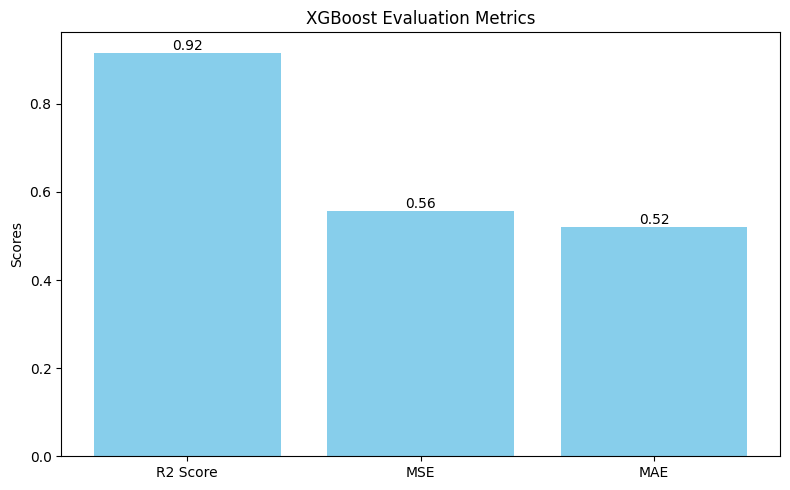

In [4]:
import matplotlib.pyplot as plt

# 평가 지표 시각화
metrics = ['R2 Score', 'MSE', 'MAE']
scores = [r2, mse, mae]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, scores, color='skyblue')

# 그래프 위에 값 출력
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.ylabel('Scores')
plt.title('XGBoost Evaluation Metrics')
plt.tight_layout()
plt.show()


In [4]:
# Fitting 5 folds for each of 8748 candidates, totalling 43740 fits
# 최적 하이퍼파라미터: {'alpha': 0, 'colsample_bytree': 0.8, 'gamma': 1, 'lambda': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.8}
# XGBoost MSE: 0.557233863074655
# XGBoost MAE: 0.5202214003966106
# XGBoost RMSE: 0.746480986412015
# XGBoost R2 Score: 0.9162074231680285

In [ ]:
param_grid = {
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.5, 1],
    'min_child_weight': [1, 3, 5],
    'alpha': [0, 0.1, 0.5],
    'lambda': [0.5, 1, 2]
}

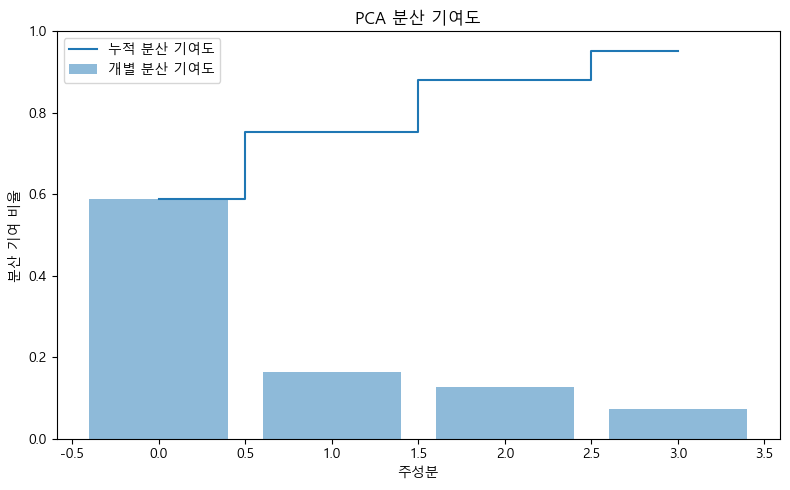

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 데이터 불러오기
data = pd.read_csv('../1. 행정동_상위변수_데이터/행정동_음주운전_합본_cp949.csv', encoding='cp949')

# Feature와 Target 분리
X = data.drop(columns=['읍면동', '음주운전 적발 건수'])
y = data['음주운전 적발 건수']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29)

# 데이터 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA 적용
pca = PCA(n_components=0.95, random_state=29)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# PCA 설명 분산 시각화
explained_variance_ratio = pca.explained_variance_ratio_
cum_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.bar(range(len(explained_variance_ratio)), explained_variance_ratio, alpha=0.5, align='center', label='개별 분산 기여도')
plt.step(range(len(cum_variance_ratio)), cum_variance_ratio, where='mid', label='누적 분산 기여도')
plt.ylabel('분산 기여 비율')
plt.xlabel('주성분')
plt.title('PCA 분산 기여도')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [5]:
from joblib import dump, load

dump(pca, 'pca_model.joblib')
dump(scaler, 'scaler.joblib')

# 모델 저장
dump(best_model, 'xgb_model_best.joblib')
print("모델이 'xgb_model_best.joblib'에 저장되었습니다.")

# 모델 로드
xgb_loaded = load('xgb_model_best.joblib')
print("저장된 모델이 로드되었습니다.")


모델이 'xgb_model_best.joblib'에 저장되었습니다.
저장된 모델이 로드되었습니다.
